# Debug python part with pycharm

I choose the following code to debug. Since we will heavily use ```db.insert()``` and ```db.intersection()``` as the basic functions, we will focus on and step into those two functions.

In [ ]:
print('----------------')
p = index.Property()
p.dimension = 4
p.dat_extension = 'data'
p.idx_extension = 'index'
# 17 decimal digits
db = index.Index(properties = p, interleaved = False)
db.insert(1, (0, 0, 0, 0, 0, 0, 99999999999999998,99999999999999998),obj = ['a']) #(x_min, y_min, z_min, x_max, y_max, z_max)
db.insert(2, (0, 0, 0, 0, 0, 0, 99999999999999998,99999999999999998),obj = ['b']) #(x_min, y_min, z_min, x_max, y_max, z_max)
db.insert(2, (0, 0, 0, 0, 0, 0, 99999999999999998,99999999999999998),obj = ['b']) #(x_min, y_min, z_min, x_max, y_max, z_max)
hits = list(db.intersection((0, 0, 0, 0, 0, 0, 99999999999999999,99999999999999999),objects = True))
[(item.object, item.bbox) for item in hits] 

The result shows as follows.

1. As is expected, the python part is only responsible for passing the value and data to C++ library (libspatialindex), and does not involve comparision or computation. The process is just as follows, using ```ctypes.c_double``` and ```c_ubyte```, where ```mins``` and ```maxs``` represents for ```[ minx,miny,minz]``` and ```[maxx,maxy,max]```. The correpsonding codes are as follows.

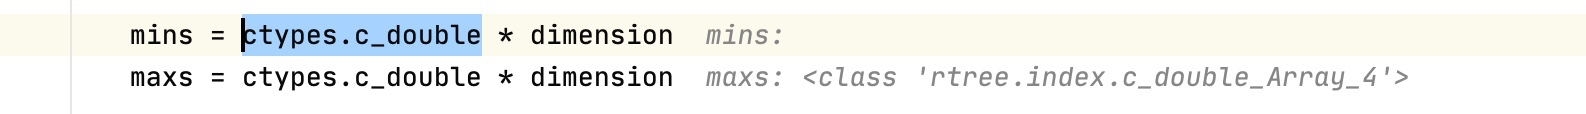

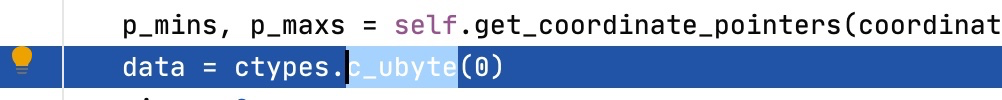

2. After passing the values, function relys on ```core.rt.Index_InsertData()``` and ```core.rt.Index_Intersects_obj()``` for inserting new boxes and retrieve the intersected boxes. The correpsonding codes are as follows.

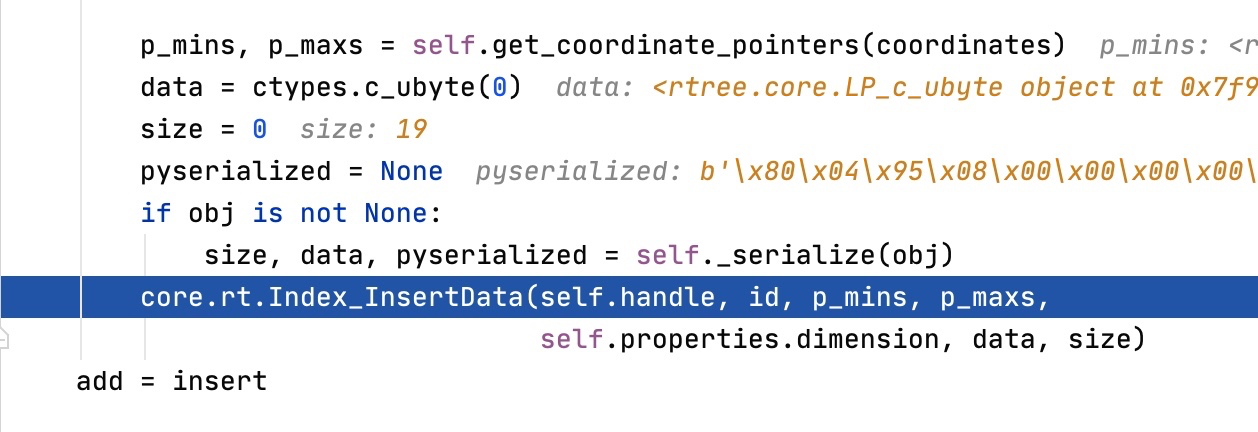

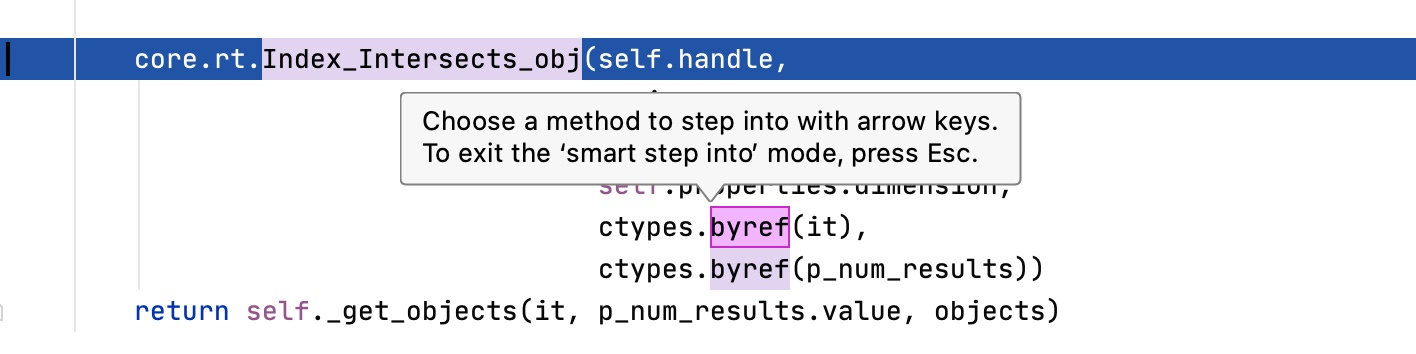

3. Finally, Based on the information about namespace, I find the corresponding functions in this file https://github.com/Toblerity/rtree/blob/master/rtree/core.py.

In [ ]:
rt.Index_InsertData.argtypes = [ctypes.c_void_p,
                                ctypes.c_int64,
                                ctypes.POINTER(ctypes.c_double),
                                ctypes.POINTER(ctypes.c_double),
                                ctypes.c_uint32,
                                ctypes.POINTER(ctypes.c_ubyte),
                                ctypes.c_uint32]
rt.Index_InsertData.restype = ctypes.c_int
rt.Index_InsertData.errcheck = check_return

In [ ]:
rt.Index_Intersects_obj.argtypes = [ctypes.c_void_p,
                                    ctypes.POINTER(ctypes.c_double),
                                    ctypes.POINTER(ctypes.c_double),
                                    ctypes.c_uint32,
                                    ctypes.POINTER(
                                        ctypes.POINTER(ctypes.c_void_p)),
                                    ctypes.POINTER(ctypes.c_uint64)]
rt.Index_Intersects_obj.restype = ctypes.c_int
rt.Index_Intersects_obj.errcheck = check_return

# Debug C++ part

Since there is none deep information can be found in python, in the next step, we will focus on the original C++ part, libspatialindex.

In the beginning, I was planning to take the same strategies as what happened in python, but because I did not find a good way to build a virtual enviroment for tracing them, finally I give up.

In turn, I just use ```grep``` to search the corresponding key word to see whether we are lucky to find it or not.

Taking the following command:

In [ ]:
git clone https://github.com/libspatialindex/libspatialindex.git
grep "Index_InsertData" -r libspatialindex

The results are as follows.

In [6]:
-> grep "Index_InsertData" -r libspatialindex
libspatialindex/test/gtest/sidx_api_test.h:      Index_InsertData(idx, nId, min, max, nDims, (uint8_t *)pszData, strlen(pszData) + 1);
libspatialindex/test/rtree/CRTree.cc:    Index_InsertData(idx, 1, min, max, 2, 0, 0);
libspatialindex/include/spatialindex/capi/sidx_api.h:SIDX_DLL RTError Index_InsertData(	IndexH index,
libspatialindex/src/capi/sidx_api.cc:SIDX_C_DLL RTError Index_InsertData(  IndexH index,
libspatialindex/src/capi/sidx_api.cc:	VALIDATE_POINTER1(index, "Index_InsertData", RT_Failure);
libspatialindex/src/capi/sidx_api.cc:						"Index_InsertData");
libspatialindex/src/capi/sidx_api.cc:						"Index_InsertData");
libspatialindex/src/capi/sidx_api.cc:						"Index_InsertData");

SyntaxError: invalid syntax (<ipython-input-6-2214e1c947e0>, line 1)

As we can see, the first 3 lines are about test code and header, we can just ingore them since they do not show the inside. Since the 4th line, the only file including this function is ```sidx_api.cc```, so I just dig a little bit into it.

There are only one function has the key word with ```Index_InsertData```. As is shown in [```sidx_api.cc```](https://github.com/libspatialindex/libspatialindex/blob/master/src/capi/sidx_api.cc#L499), the function is as follows.

As is shown, the procedure is quite clear, firstly, it will test whether the input is a point or not, then based on either points or boxes, it uses ```index().insertData()``` to insert the them.

The reason why the author seperately deals with points and boxes may because of time complexity but not quite sure. However, one surely thing is that the author mistakely put ```std::numeric_limits<double>::epsilon();``` in many place for appoximation without scaling. It is reasonable for the author to intend to use it, but the usage is totally incorrect according to this https://stackoverflow.com/questions/48133572/what-can-stdnumeric-limitsdoubleepsilon-be-used-for. In short, it should use in the view of magnitudes.

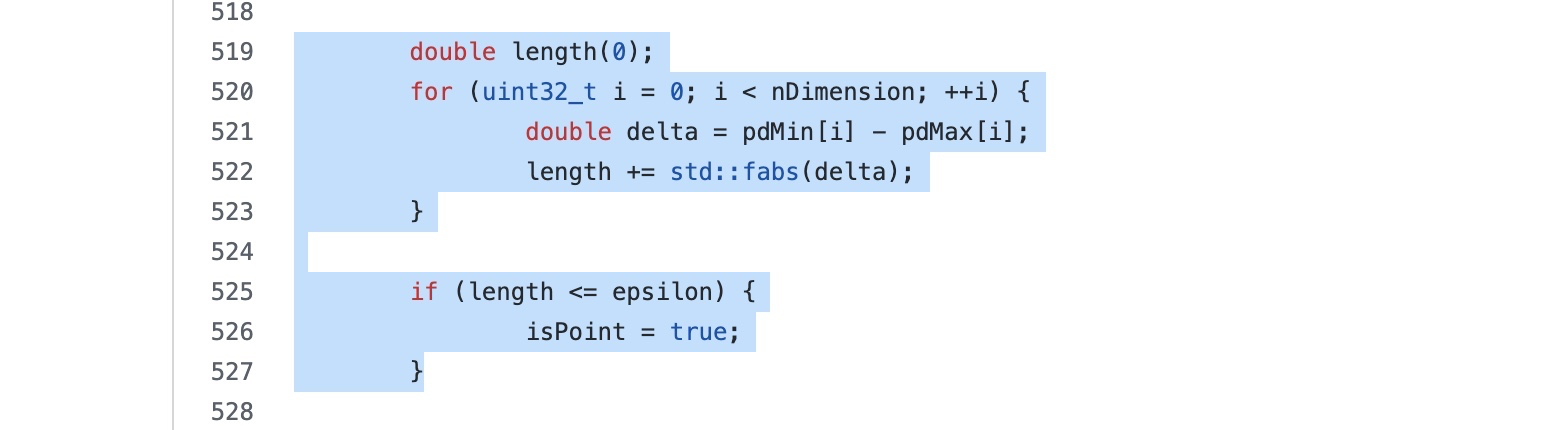